Attempting to use Sørensen–Dice coefficient as means of grouping similar data entries
- https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
- Provides a fractional score between 0 and 1
- Does not obey triangle equality, but that does not seem like a downside at this point

Following implementation is shamelessly copied from https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Dice%27s_coefficient#Python

**2022-10-26 note:** Making use o the implementation that will count 'AA' and 'AAAA' as only one match to minimize the impact of column seperator character. This can be improved by removing all duples with the seperator character.

In [1]:
""" more orthodox and robust implementation """
def dice_coefficient(a, b):
    """dice coefficient 2nt/(na + nb)."""
    if not len(a) or not len(b): return 0.0
    if len(a) == 1:  a=a+u'.'
    if len(b) == 1:  b=b+u'.'
    
    a_bigram_list=[]
    for i in range(len(a)-1):
      a_bigram_list.append(a[i:i+2])
    b_bigram_list=[]
    for i in range(len(b)-1):
      b_bigram_list.append(b[i:i+2])
      
    a_bigrams = set(a_bigram_list)
    b_bigrams = set(b_bigram_list)
    overlap = len(a_bigrams & b_bigrams)
    dice_coeff = overlap * 2.0/(len(a_bigrams) + len(b_bigrams))
    return dice_coeff

Pseudocode

In [2]:
"""
define dice score threshold
load dataframe from Excel sheet
define list of columns that can be excluded from analysis
make a new column which is every included column concatenated
    defines the strings used in the analysis, will refer to them as entries
make a new column called sort index
    each "cluster" will share an integer
    assign initial value of 0
sort_index = 1
for every row
    if row[sort index] = 0
        row[sort index] = sort_index
        for every other row (probably implement as another for every row)
            if other row[sort index] = 0
                dice score (entry, other entry)
                if threshold < dice score
                    other row[sort index] = sort index
        sort index ++
"""

'\ndefine dice score threshold\nload dataframe from Excel sheet\ndefine list of columns that can be excluded from analysis\nmake a new column which is every included column concatenated\n    defines the strings used in the analysis, will refer to them as entries\nmake a new column called sort index\n    each "cluster" will share an integer\n    assign initial value of 0\nsort_index = 1\nfor every row\n    if row[sort index] = 0\n        row[sort index] = sort_index\n        for every other row (probably implement as another for every row)\n            if other row[sort index] = 0\n                dice score (entry, other entry)\n                if threshold < dice score\n                    other row[sort index] = sort index\n        sort index ++\n'

# 2022-10-25

In [3]:
path = "F:/EXCEL Sheets for ADNAN to MERGE 2022/merged.xlsx"
import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

Import the Excel sheet

In [4]:
df = pd.read_excel(path, dtype = str)
df = df.fillna('')
ic(df.columns)
ic(df.shape)

ic| df.columns: Index(['Unnamed: 0', 'Letter', 'Color', 'Status/Notes - Quickbooks - A',
                       'Background', 'Title', 'First Name', 'Middle', 'Last Name', 'Amount',
                       'Organization', 'Additional/Related Contact', 'Main Phone', 'Mobile',
                       'Home', 'Work', 'Fax', 'Main Email', 'Secondary Email',
                       'Additional Email', 'Work/School Email', 'Street Address', 'City',
                       'State', 'Zip Code', 'Status Notes', 'Company/Organization',
                       'Bad Status/Notes - B', 'Address',
                       'Status only noted 8-15-2018 in retrospect', 'Unnamed 1', 'Unnamed 2',
                       'Unnamed 3', 'Unnamed 4', 'Unnamed 5', 'Company', 'STATUS', 'Source',
                       'Interfaith', 'Unnamed: 12', 'Unnamed: 13'],
                      dtype='object')
ic| df.shape: (9504, 41)


(9504, 41)

Creating a column which is the other columns concatenated together, with a seperator character between them

In [5]:
cols_to_concat = ['Background','Title', 'First Name', 'Middle', 'Last Name', 'Organization', 'Additional/Related Contact', 'Main Phone', 'Mobile', 'Home', 'Work','Fax', 'Main Email', 'Secondary Email', 'Additional Email','Work/School Email', 'Street Address', 'City','Zip Code','Status Notes', 'Company/Organization', 'Address','Unnamed 1','Unnamed 2', 'Unnamed 3', 'Unnamed 4', 'Unnamed 5', 'Company', 'Unnamed: 12', 'Unnamed: 13']
df['Row'] = ""
df['Row'].shape
for col in cols_to_concat:
    df['Row'] = df['Row'] + '|' + df[col]

Take n rows and compute the SDE between that row and every other row

In [6]:
n = 300
SDC = np.empty((n,df.shape[0]))
ic(SDC.shape)
samples = df.sample(n)
ic(samples.shape)

i = 0 #yes, there must be a more efficient way to do this
for str1 in samples['Row']:
    j = 0
    for str2 in df['Row']:
        SDC[i,j] = dice_coefficient(str1,str2)
        j = j+1
    i = i+1
ic([i,j])

ic| SDC.shape: (300, 9504)
ic| samples.shape: (300, 42)
ic| [i,j]: [300, 9504]


[300, 9504]

I want to see the trends in similarity between from least to most similar

In [8]:
# percent above the mean
ic(np.mean(SDC > np.mean(SDC)))
# percent greater than one standard deviation above the mean
ic(np.mean(SDC > np.mean(SDC)+np.std(SDC)))

ic| np.mean(SDC > np.mean(SDC)): 0.43760451739618406
ic| np.mean(SDC > np.mean(SDC)+np.std(SDC)): 0.13764976150392816


0.13764976150392816

**Implementing the algoirthm**

In [9]:
"""
define dice score threshold
load dataframe from Excel sheet
define list of columns that can be excluded from analysis
make a new column which is every included column concatenated
    defines the strings used in the analysis, will refer to them as entries
make a new column called sort index
    each "cluster" will share an integer
    assign initial value of 0
sort_index = 1
for every row
    if row[sort index] = 0
        row[sort index] = sort_index
        for every other row (probably implement as another for every row)
            if other row[sort index] = 0
                dice score (entry, other entry)
                if threshold < dice score
                    other row[sort index] = sort index
        sort index ++
"""
threshold = 0.5
df['Cluster'] = 0
cluster = 1

n = df.shape[0]
ic(n)

time_per_cluster = []

for i in tqdm(range(n)):
    if df['Cluster'][i] == 0:
        
        start = time.time()
        
        df['Cluster'][i] = cluster
        for j in range(n):
            if df['Cluster'][j] == 0:
                coeff = dice_coefficient(df['Row'][i],df['Row'][j])
                if threshold < coeff:
                    df['Cluster'][j] = cluster
        cluster = cluster+1
        
        end = time.time()
        time_per_cluster.append(end-start)

ic| n: 9504
  0%|                                                                                         | 0/9504 [00:00<?, ?it/s]C:\Users\CAIR OHIO ADMIN\AppData\Local\Temp\ipykernel_29288\2053716471.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'][i] = cluster
C:\Users\CAIR OHIO ADMIN\AppData\Local\Temp\ipykernel_29288\2053716471.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'][j] = cluster
100%|██████████████████████████████████████████████████████████████████████████████| 9504/9504 [06:52<00:00, 23.06it/s]


In [10]:
sorted_df = df

path = "F:/EXCEL Sheets for ADNAN to MERGE 2022/"
df.to_excel(path+'sorted.xlsx')

<AxesSubplot:>

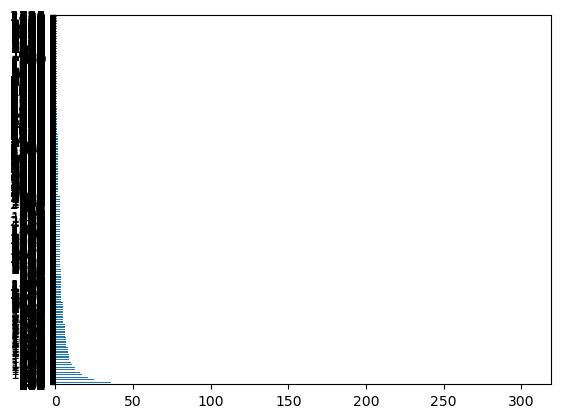

In [17]:
df['Cluster'].value_counts().plot(kind = 'barh')

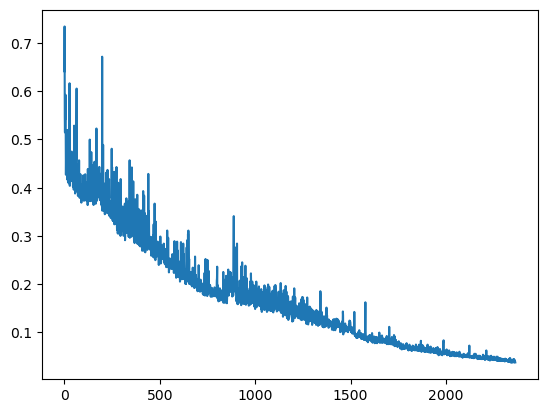

In [12]:
plt.plot(time_per_cluster)
plt.show()